In [156]:
import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
from scipy import stats
import talib
from ggplot import *
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from matplotlib.finance import candlestick2_ohlc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

In [180]:
data = pd.read_csv('USDRUB_150228_180301.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'V'], header=0)
data.index = data.apply(lambda row: datetime.strptime(str(row['date']) + ' ' + str(row['time']), '%d/%m/%y %H:%M:%S'), axis=1)
data.drop(data[data.V < 10000].index, inplace=True)
data.drop(['date', 'time'], axis=1, inplace=True)

In [236]:
lag = 200
data['rsi'] = talib.RSI(np.array(data['open']), timeperiod=3)
data['sma'] = talib.SMA(np.array(data['open']), timeperiod=lag)
data['trend'] = data['open'] - data['sma']
data['spread'] = data.apply(lambda row: row['close'] - row['open'], axis=1)
data['class'] = data['spread'].apply(lambda x: 1 if x > 0 else -1)

X = data[['rsi', 'trend']].iloc[lag:,:]
y = data.iloc[lag:, 9]

train_share = int(0.7 * X.shape[0])
X_train, y_train = X.iloc[:train_share, :], y.iloc[:train_share]
X_test, y_test = X.iloc[train_share:, :], y.iloc[train_share:]

svc_clf = SVC(class_weight='balanced', random_state=42)
svc_clf.fit(X_train, y_train)
y_pred = svc_clf.predict(X_train)
X_train['class_pred'] = y_pred
X_train['class_real'] = y_train
print(accuracy_score(y_train, y_pred))

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.607503152585


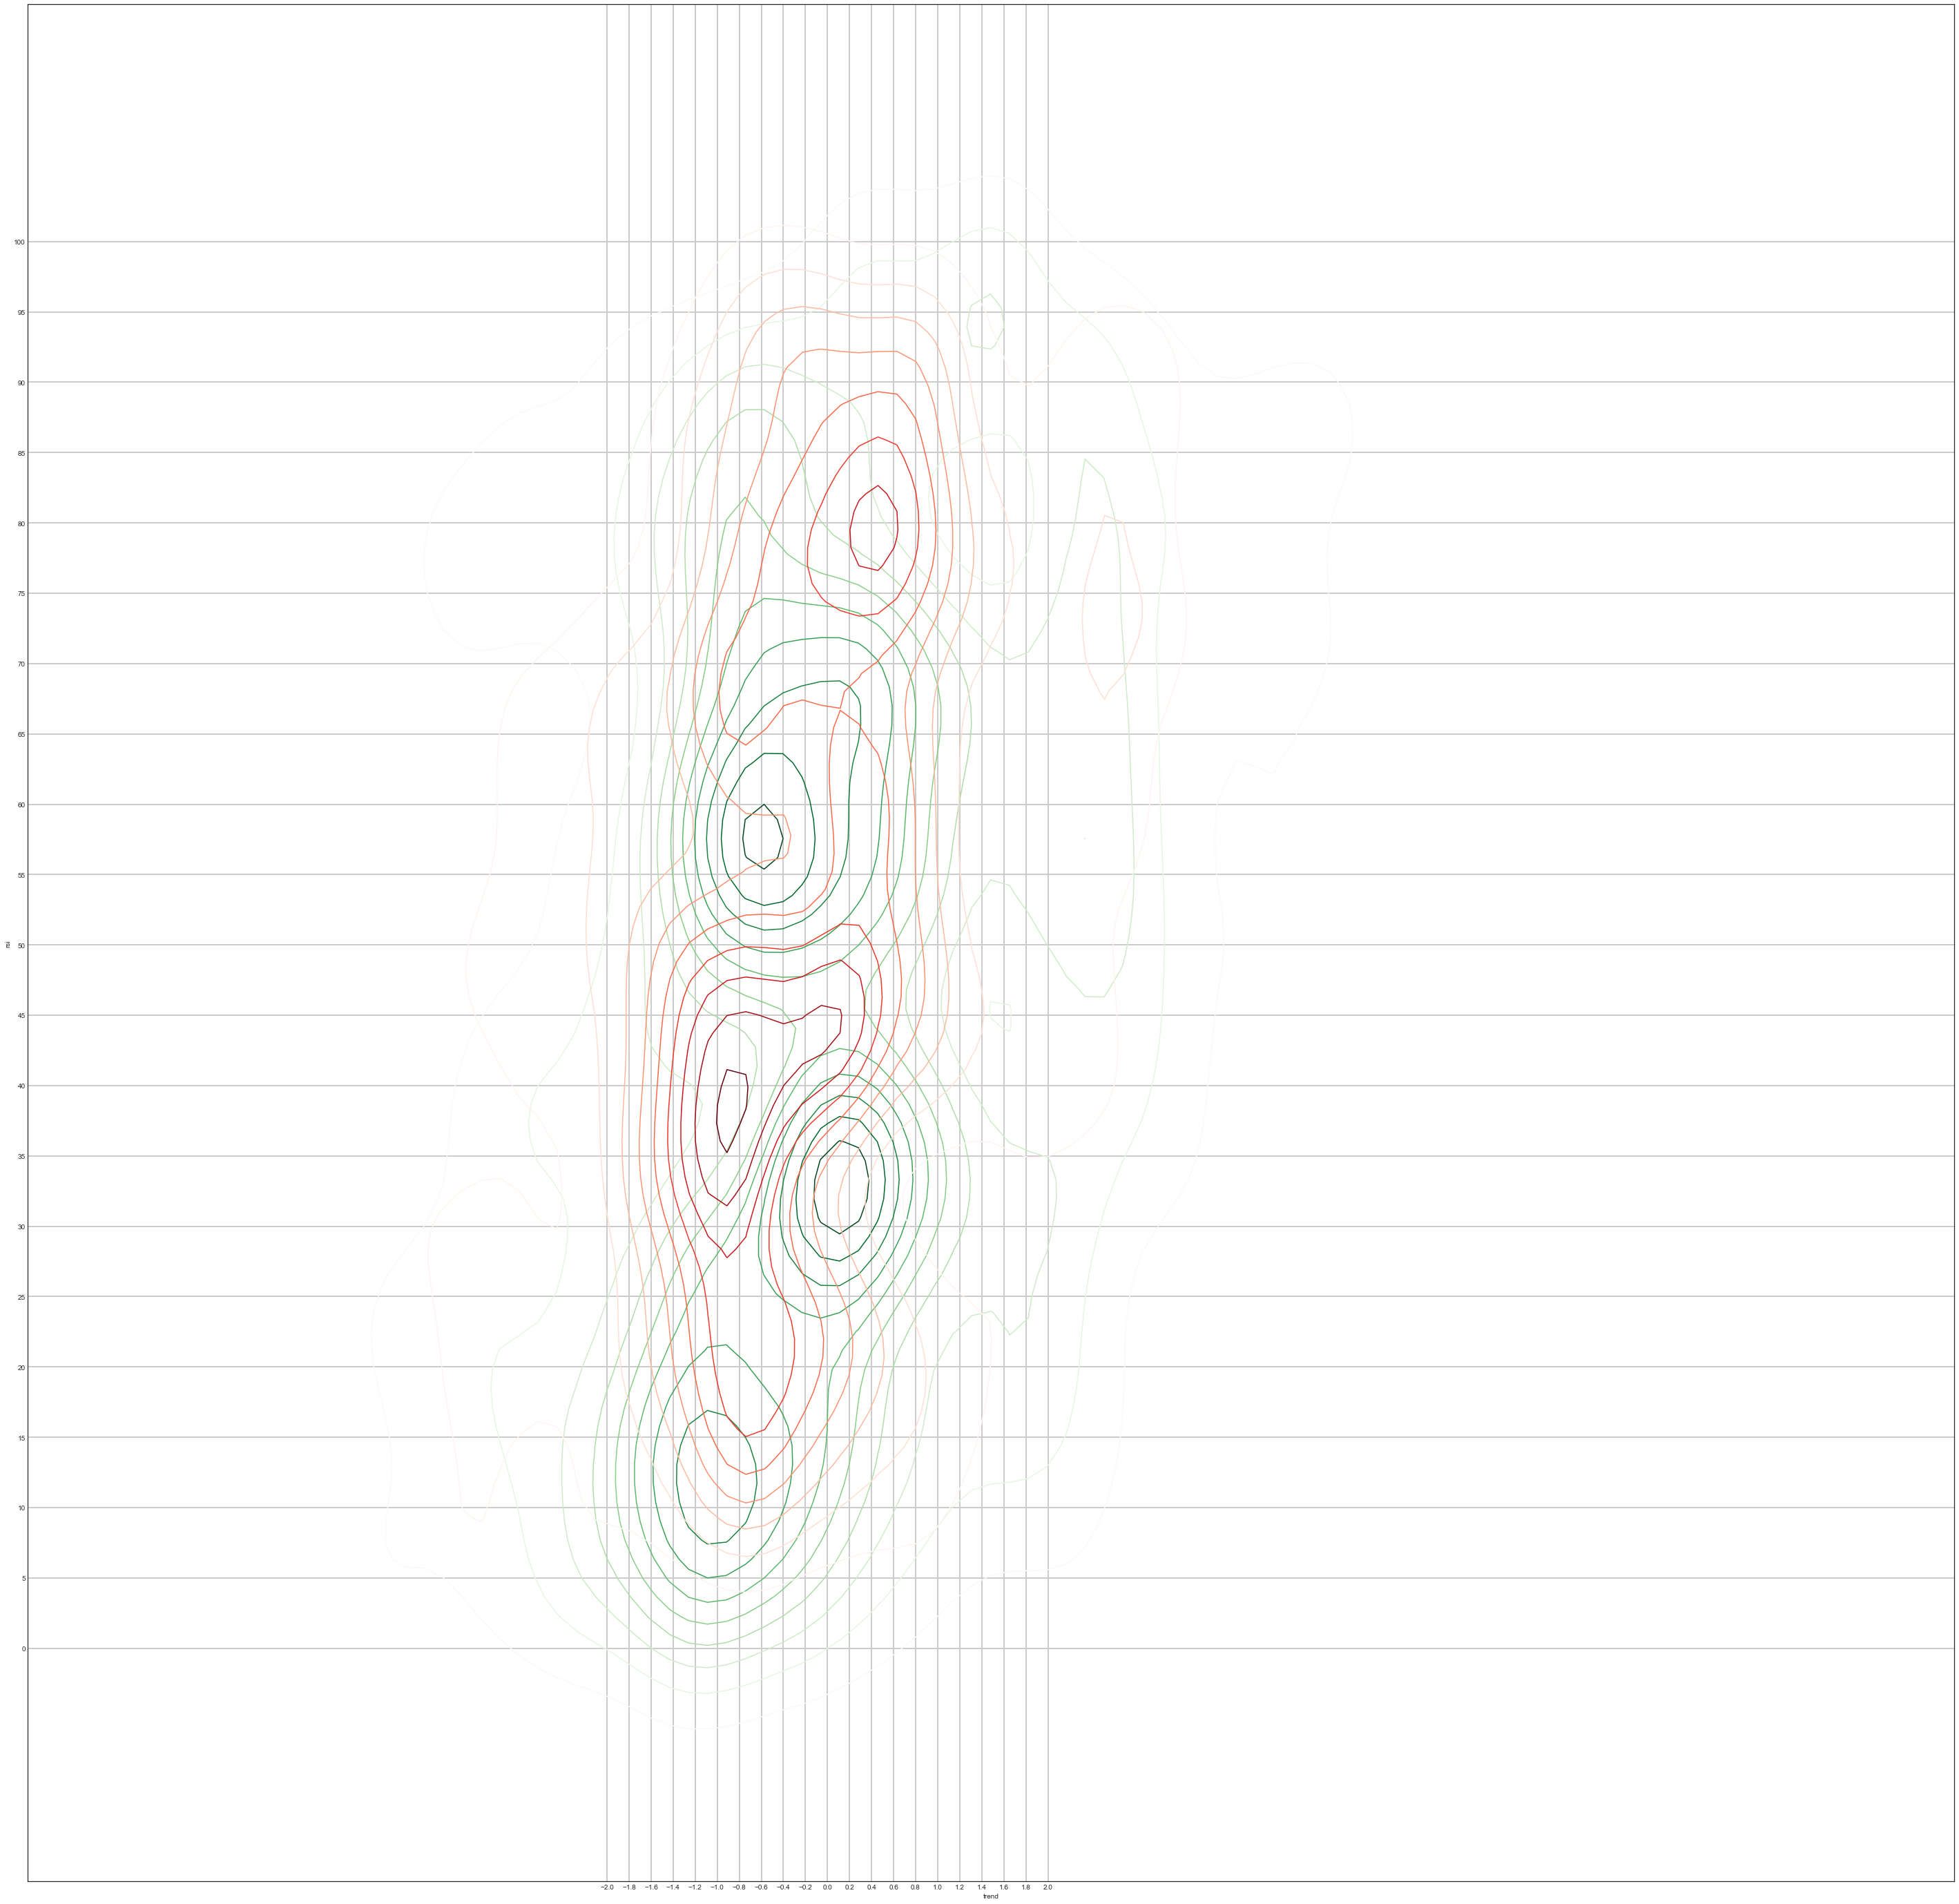

In [276]:
fig, ax = plt.subplots(figsize=(50,50))
sns.kdeplot(X_train['trend'][X_train['class_pred'] == 1], X_train['rsi'][X_train['class_pred'] == 1], cmap='Greens', ax=ax, shade_lowest=False)
sns.kdeplot(X_train['trend'][X_train['class_pred'] == -1], X_train['rsi'][X_train['class_pred'] == -1], cmap='Reds', ax=ax, shade_lowest=False)
ax.set_yticks(np.linspace(0, 100, 21))
ax.set_xticks(np.linspace(-2, 2, 21))
ax.grid(linestyle='-', linewidth=2)
plt.savefig('usdrur_rsi_trend.jpg', dpi=100)


In [241]:
X_test['real_class'] = y_test

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [253]:
X_test['long1'] = X_test.apply(lambda row: 1 if ((row['rsi'] > 7) and
                                                 (row['rsi'] < 12.5) and
                                                 (row['trend'] > -1.2) and
                                                 (row['trend'] < - 0.8)) else 0, axis=1)
X_test['long2'] = X_test.apply(lambda row: 1 if ((row['rsi'] > 30) and
                                                 (row['rsi'] < 35) and
                                                 (row['trend'] > -0.2) and
                                                 (row['trend'] <  0.4)) else 0, axis=1)
X_test['long3'] = X_test.apply(lambda row: 1 if ((row['rsi'] > 55) and
                                                 (row['rsi'] < 60) and
                                                 (row['trend'] > -0.8) and
                                                 (row['trend'] < - 0.4)) else 0, axis=1)
X_test['short1'] = X_test.apply(lambda row: -1 if ((row['rsi'] > 35) and
                                                 (row['rsi'] < 42.5) and
                                                 (row['trend'] > -1.0) and
                                                 (row['trend'] < - 0.8)) else 0, axis=1)
X_test['short2'] = X_test.apply(lambda row: -1 if ((row['rsi'] > 78) and
                                                 (row['rsi'] < 82.5) and
                                                 (row['trend'] > 0.2) and
                                                 (row['trend'] < 0.6)) else 0, axis=1)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [277]:
print X_test.loc[(X_test['long1'] == 1) & (X_test['real_class'] == 1)].shape[0] / float(X_test.loc[(X_test['long1'] == 1)].shape[0])
print X_test.loc[(X_test['long2'] == 1) & (X_test['real_class'] == 1)].shape[0] / float(X_test.loc[(X_test['long2'] == 1)].shape[0])
print X_test.loc[(X_test['long3'] == 1) & (X_test['real_class'] == 1)].shape[0] / float(X_test.loc[(X_test['long3'] == 1)].shape[0])
print X_test.loc[(X_test['short1'] == -1) & (X_test['real_class'] == -1)].shape[0] / float(X_test.loc[(X_test['short1'] == -1)].shape[0])
print X_test.loc[(X_test['short2'] == -1) & (X_test['real_class'] == -1)].shape[0] / float(X_test.loc[(X_test['short2'] == -1)].shape[0])

0.5625
0.5
0.357142857143
0.5
0.642857142857


In [291]:
X_test.loc[(X_test['long1'] == 1) | (X_test['short2'] == -1)].join(data[['open','close', 'V']])

,rsi,trend,real_class,long1,long2,long3,short1,short2,open,close,V
2017-03-17 21:00:00,10.346567,-1.194150,-1,1,0,0,0,0,57.3210,57.2324,21768
2017-03-24 15:00:00,8.678890,-1.063698,1,1,0,0,0,0,57.2049,57.2310,15282
2017-03-24 17:00:00,11.774680,-1.119145,-1,1,0,0,0,0,57.1344,57.0634,21760
2017-03-24 18:00:00,7.472533,-1.195715,1,1,0,0,0,0,57.0504,57.0920,20058
2017-05-02 14:00:00,81.896678,0.566745,-1,0,0,0,0,-1,57.0434,57.0110,17307
2017-05-15 16:00:00,9.839034,-0.914376,1,1,0,0,0,0,56.2402,56.2463,23538
2017-05-15 17:00:00,8.501018,-0.946426,1,1,0,0,0,0,56.2088,56.4020,29258
2017-05-25 11:00:00,9.234656,-1.113568,-1,1,0,0,0,0,56.0800,56.0370,30193
2017-05-25 12:00:00,7.520508,-1.160928,1,1,0,0,0,0,56.0255,56.1460,39834
2017-06-09 22:00:00,79.422634,0.378569,1,0,0,0,0,-1,57.0025,57.0262,15202


In [287]:
data.iloc[6676]

open         57.050400
high         57.183600
low          56.995300
close        57.092000
V         20058.000000
rsi           7.472533
sma          58.246115
trend        -1.195715
spread        0.041600
class         1.000000
Name: 2017-03-24 18:00:00, dtype: float64

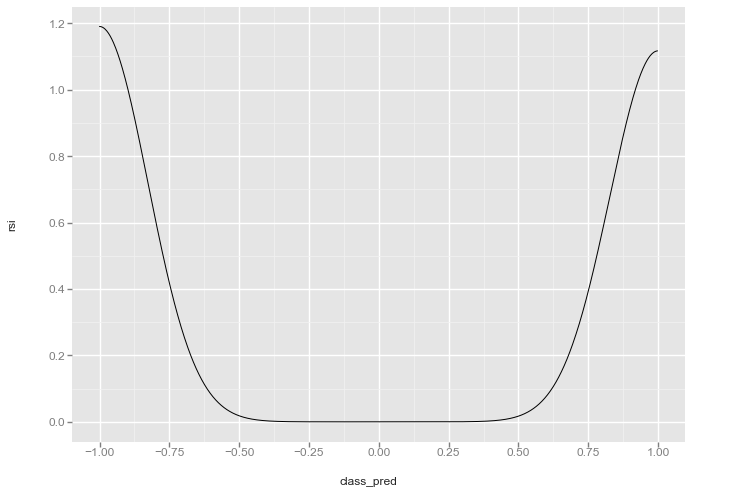

<ggplot: (26472620)>

In [163]:
ggplot(X_train, aes(x='sma',y='rsi')) + g

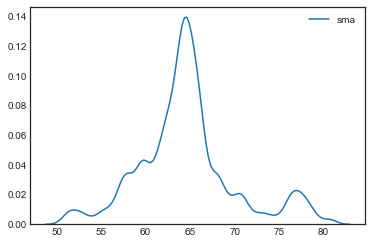

In [179]:
sns.kdeplot(X_train['sma'][X_train['class_pred'] == 1])

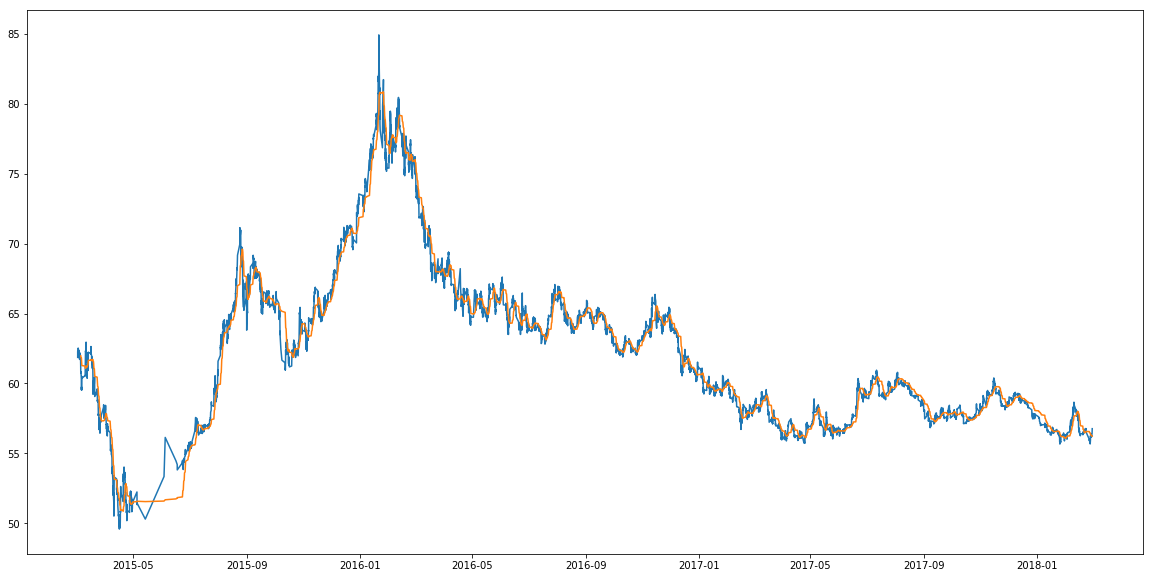

In [75]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data.open)
ax.plot(data.sma)

In [34]:
df = data.iloc[9100:, :]

Dickey–Fuller test: p=0.582243


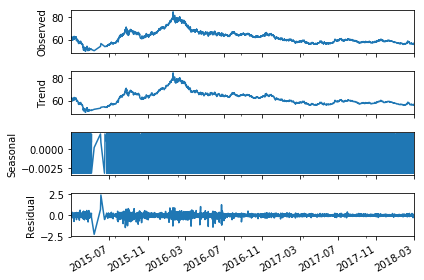

In [63]:
print('Dickey–Fuller test: p=%f' % sm.tsa.stattools.adfuller(data.close)[1])
sm.tsa.seasonal_decompose(data.close, freq=).plot()
plt.show()

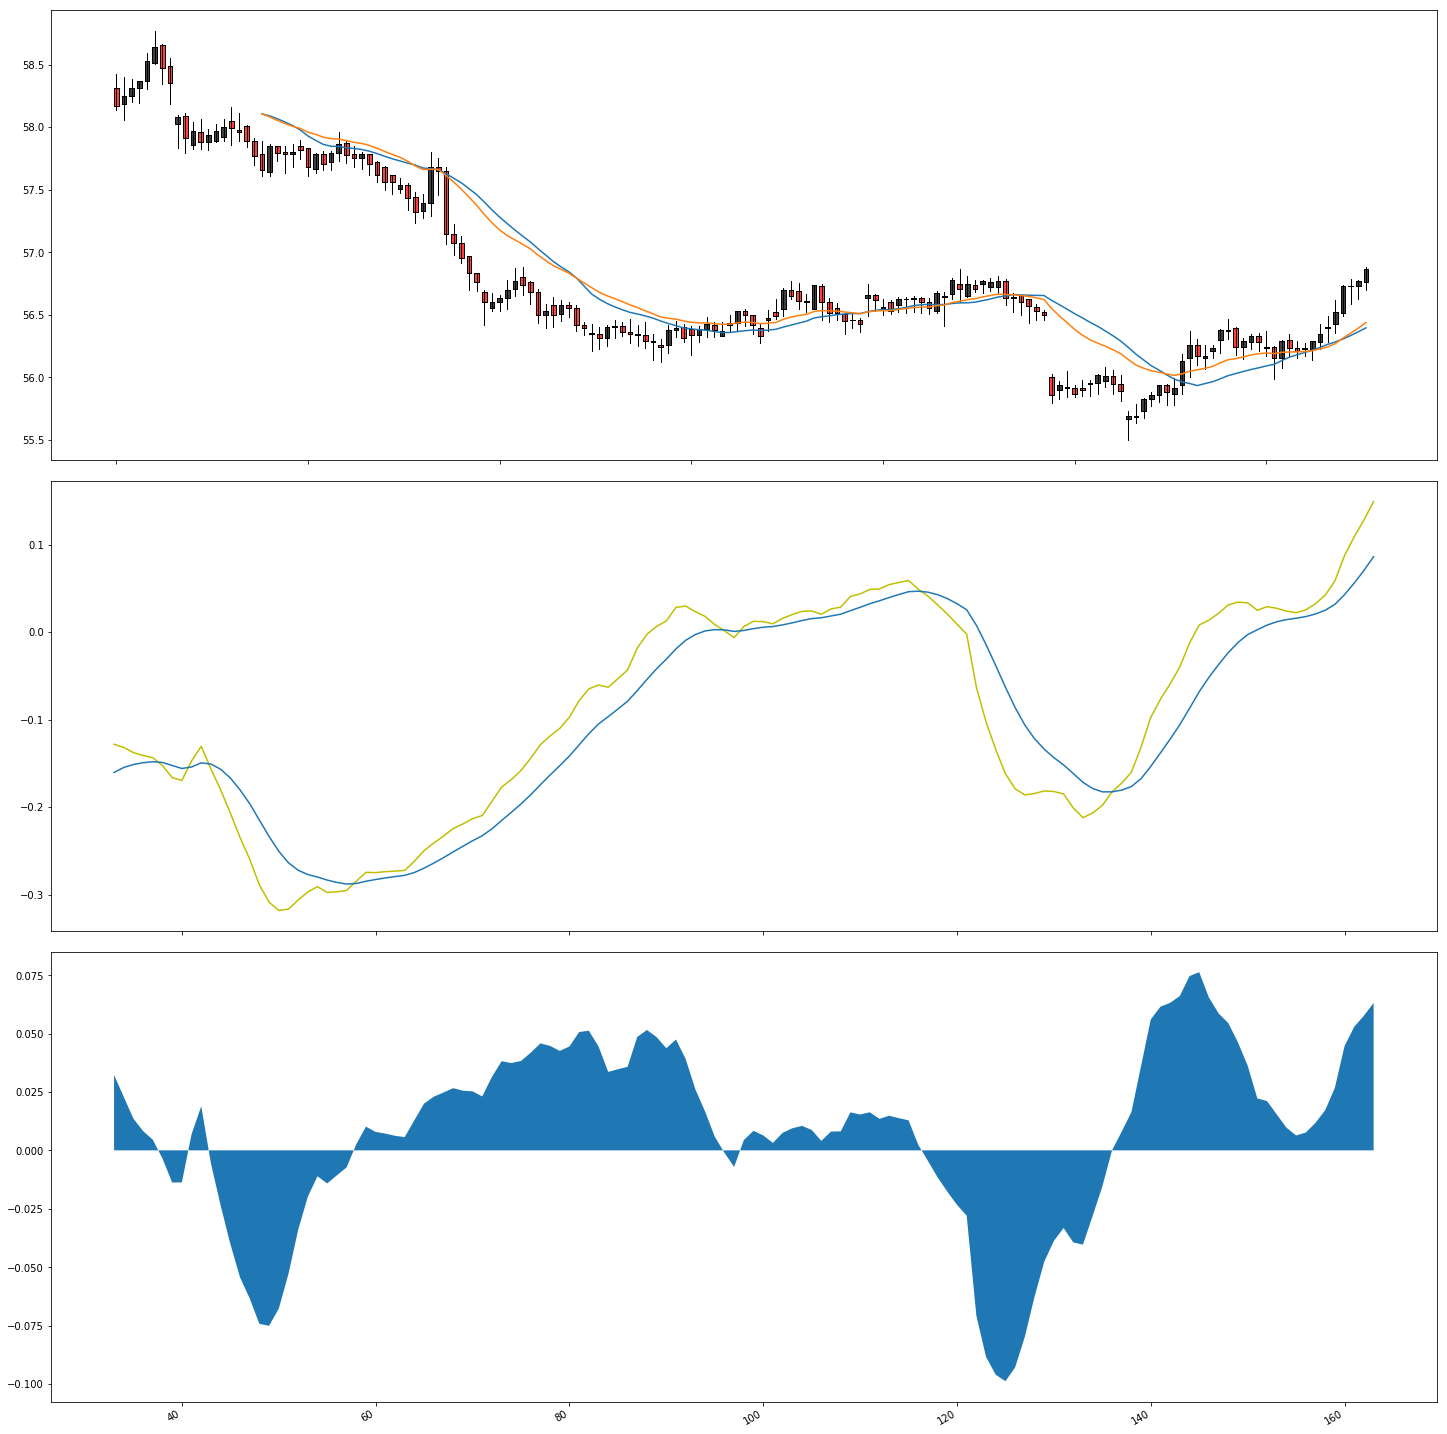

In [57]:
xdate=data.index

fig, ax = plt.subplots(3, figsize=(20,20))

candlestick2_ohlc(ax[0],df['open'],df['high'],df['low'],df['close'],width=0.6)

fig.autofmt_xdate()
fig.tight_layout()

sma = talib.SMA(np.array(df['close']), timeperiod=20)
ax[0].plot(sma)

ema = talib.EMA(np.array(df['close']), timeperiod=20)
ax[0].plot(ema)

macd, macdsignal, macdhist = talib.MACD(np.array(df['close']), fastperiod=12, slowperiod=26, signalperiod=9)
ax[1].plot(macd, color="y")
ax[1].plot(macdsignal)

hist_data = []
for elem in macdhist:
    if not np.isnan(elem):
        v = 0 if np.isnan(elem) else elem
        hist_data.append(v*100)
ax[2].fill_between([x for x in range(len(macdhist))], 0,macdhist)


plt.show()

,open,high,low,close,V
2018-02-09 17:00:00,58.3116,58.4272,58.1334,58.1700,34740
2018-02-09 18:00:00,58.1878,58.3994,58.0599,58.2493,40459
2018-02-09 19:00:00,58.2496,58.3813,58.1970,58.3113,34899
2018-02-09 20:00:00,58.3143,58.3722,58.1918,58.3705,25786
2018-02-09 21:00:00,58.3679,58.5935,58.3020,58.5299,29109
